In [16]:
import numpy as np

from dateutil.relativedelta import relativedelta

def TimeInterval(interval):
    tag = interval[-1].lower()
    value = int(interval[:-1])
    if tag == "d":
        return relativedelta(days=value)
    elif tag == "m":
        return relativedelta(months=value)
    elif tag == "y":
        return relativedelta(years=value)
    else:
        raise ValueError(f"Unable to convert {interval}, probably wrong units.")
    
def generate_dates(start_date, end_date, frequency="1y"):
    if isinstance(end_date, str):
        end_date = start_date + TimeInterval(end_date)
    d = start_date
    dates = [start_date]
    while True:
        d += TimeInterval(frequency)
        if d < end_date:
            dates.append(d)
        else:
            dates.append(end_date)
            break
    return dates

class DiscountCurve:
  def __init__(self, pillar_dates, discount_factors):
    self.discount_factors = np.array(discount_factors)
    self.pillar_dates = pillar_dates

  def df(self, adate):
    pillars = [p.toordinal() for p in self.pillar_dates]
    return np.interp(adate.toordinal(), pillars, self.discount_factors)

In [28]:
class OvernightIndexSwap:
    def __init__(self, nominal, start_date, maturity, fixed_rate, side=1):
        self.nominal = nominal
        self.fixed_rate = fixed_rate
        self.payment_dates = generate_dates(start_date, maturity)
        self.side = side
      
    def npv_floating(self, dc):
        return self.nominal * (dc.df(self.payment_dates[0]) - dc.df(self.payment_dates[-1]))
  
    def npv_fixed(self, dc):
        val = 0
        for i in range(1, len(self.payment_dates)):
            val += dc.df(self.payment_dates[i]) * \
                    (self.payment_dates[i] - self.payment_dates[i-1]).days/360 
        return self.nominal*self.fixed_rate*val
  
    def npv(self, dc):
        return self.side*(self.npv_floating(dc) - self.npv_fixed(dc))

    def fair_value_strike(self, dc):
        den = self.npv_fixed_leg(dc)/self.fixed_rate
        num = self.npv_floating_leg(dc)
        return num/den

In [17]:
import pandas as pd

df = pd.read_excel("https://github.com/matteosan1/finance_course/raw/refs/heads/develop/input_files/ois_2024_10_14.xlsx",
                   index_col="maturities")
print (df.head())

              quotes
maturities          
7D          3.414000
14D         3.295500
1M          3.229000
2M          3.209205
3M          3.127103


In [29]:
from datetime import date

obs_date = date.today()
oiss = []
pillars = []
for i in range(len(df)):
  maturity = df.index[i]
  quote = df['quotes'][maturity]*0.01
  oiss.append(OvernightIndexSwap(1, obs_date, maturity, quote))

for i in range(len(df)):
  maturity = df.index[i]
  pillars.append(obs_date + TimeInterval(maturity))

In [30]:
from scipy.optimize import newton

class Bootstrap:
    def __init__(self, obs_date, objects):
        self.obs_date = obs_date
        self.objects = objects

    def objective_function(self, x, i, xs, curve, kwargs):
        pillars = [self.obs_date] + [self.objects[j].payment_dates[-1] for j in range(i+1)]
        c = curve(pillars, [1] + xs + [x])
        return self.objects[i].npv(c, **kwargs)

    def run(self, curve, guess=1.0, kwargs={}):
        x = []    
        for i in range(len(self.objects)):
            res = newton(self.objective_function, guess, args=(i, x, curve, kwargs))
            x.append(res)
        return x

In [31]:
bootstrap = Bootstrap(obs_date, oiss)
dfs = bootstrap.run(DiscountCurve)

discount_curve = DiscountCurve(pillars, dfs)

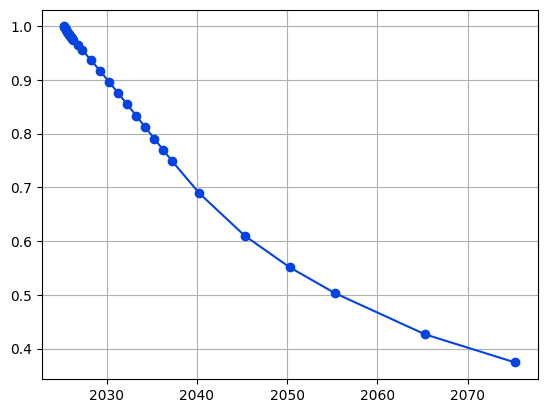

In [32]:
import matplotlib.pyplot as plt

plt.plot(discount_curve.pillar_dates, dfs, marker="o", color="xkcd:blue")
plt.grid(True)
plt.show()

In [26]:
import numpy as np

from datetime import date

rates = []
for i in range(1, len(discount_curve.pillar_dates)):
    tau = (discount_curve.pillar_dates[i]-date.today()).days/365
    rates.append(-np.log(dfs[i])/tau)

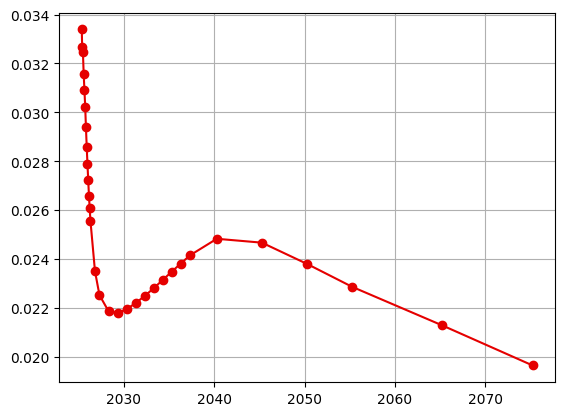

In [27]:
import matplotlib.pyplot as plt

plt.plot(discount_curve.pillar_dates[1:], rates, marker="o", color="xkcd:red")
plt.grid(True)
plt.show()